In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("updated.csv", low_memory=False)
df.head()

,Age (days),#ofPosts,Posts/Day,OddsBeingBot
0,4256,23279,5.469690,0.020441
1,4124,525,0.127304,0.073133
2,4313,8146,1.888709,0.041325
3,4226,3510,0.830573,0.014311
4,4351,8146,1.872213,0.058340


In [2]:
df.dtypes

Age (days)        int64
#ofPosts          int64
Posts/Day       float64
OddsBeingBot    float64
dtype: object

In [3]:
df = df.drop('Posts/Day', axis=1)
df.head()

,Age (days),#ofPosts,OddsBeingBot
0,4256,23279,0.020441
1,4124,525,0.073133
2,4313,8146,0.041325
3,4226,3510,0.014311
4,4351,8146,0.058340


## Viz

### Quick heatmap for correlation

<AxesSubplot:>

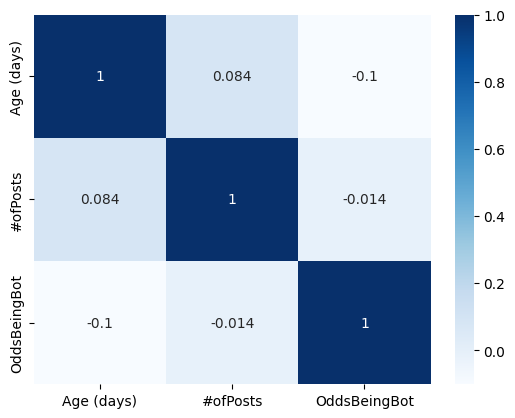

In [4]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot=True)

#### Lots of weak correlations, time to model

## Modeling

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.tree import DecisionTreeRegressor

### Mean avg, squared, and r squared scores function

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval(y_true, y_pred):  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

### Train Test Split

In [7]:
X = df.drop(columns=['OddsBeingBot'])
y = df['OddsBeingBot']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()

In [8]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Decision Tree

In [9]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_pipe = make_pipeline(scaler, dec_tree)
dec_pipe.fit(X_train, y_train)
print('Train')
eval(y_train, dec_pipe.predict(X_train))
print('Test')
eval(y_test, dec_pipe.predict(X_test))

Train
scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.01 
R2: 1.00
Test
scores: 
MAE: 0.23 
MSE: 0.12 
RMSE: 0.34 
R2: -1.02


### Tuning, these are bad scores

In [10]:
dec_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('decisiontreeregressor', DecisionTreeRegressor(random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'decisiontreeregressor': DecisionTreeRegressor(random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'decisiontreeregressor__ccp_alpha': 0.0,
 'decisiontreeregressor__criterion': 'squared_error',
 'decisiontreeregressor__max_depth': None,
 'decisiontreeregressor__max_features': None,
 'decisiontreeregressor__max_leaf_nodes': None,
 'decisiontreeregressor__min_impurity_decrease': 0.0,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__min_samples_split': 2,
 'decisiontreeregressor__min_weight_fraction_leaf': 0.0,
 'decisiontreeregressor__random_state': 42,
 'decisiontreeregressor__splitter': 'best'}

#### We'll be tuning with max_leaf_nodes, min_samples_leaf, and max_depth

,Test Score,Train Score
2,0.02287,0.01479
3,0.022431,0.01895
4,0.017351,0.02466
5,0.011792,0.035708
6,-0.005236,0.04982


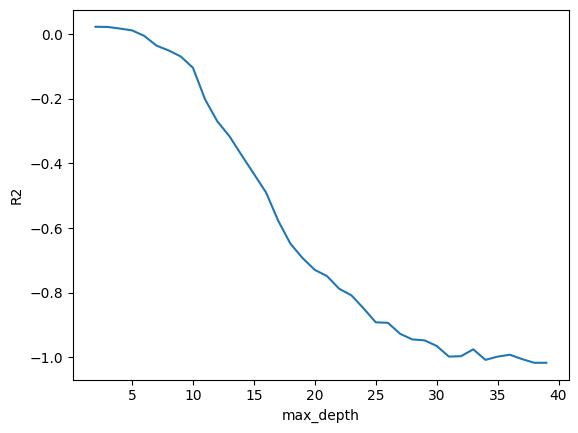

In [11]:
depths = list(range(2, 40))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

2 is the best depth

In [12]:
dec_tree_fin = DecisionTreeRegressor(max_depth = 2, random_state = 42)
dec_tree_fin.fit(X_train, y_train)
print('Training')
eval(y_train, dec_tree_fin.predict(X_train))
print('Testing')
eval(y_test, dec_tree_fin.predict(X_test))

Training
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.01
Testing
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


,Test Score,Train Score
2,0.02287,0.01479
30,0.02287,0.01479
23,0.02287,0.01479
24,0.02287,0.01479
25,0.02287,0.01479


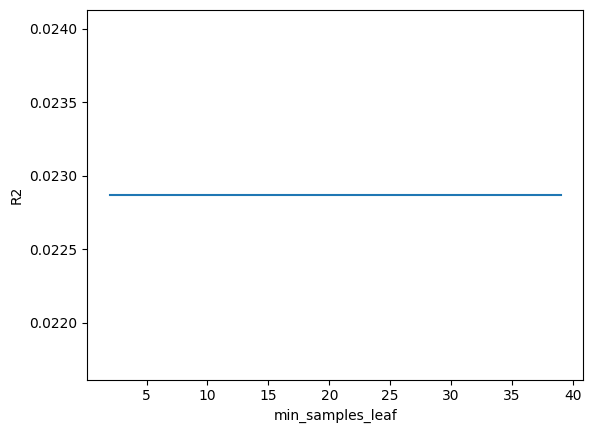

In [13]:
samples = list(range(2, 40))
scores2 = pd.DataFrame(index=samples, columns=['Test Score','Train Score'])
for sample in samples:
    dec_tree_fin = DecisionTreeRegressor(min_samples_leaf=sample, max_depth = 2, random_state=42)
    dec_tree_fin.fit(X_train, y_train)
    train_score = dec_tree_fin.score(X_train, y_train)
    test_score = dec_tree_fin.score(X_test, y_test)
    scores2.loc[sample, 'Train Score'] = train_score
    scores2.loc[sample, 'Test Score'] = test_score
plt.plot(samples, scores2['Test Score'])
plt.xlabel('min_samples_leaf')
plt.ylabel('R2');
sorted_scores2 = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores2.head()

All the same

,Test Score,Train Score
21,0.02287,0.01479
22,0.02287,0.01479
24,0.02287,0.01479
25,0.02287,0.01479
26,0.02287,0.01479


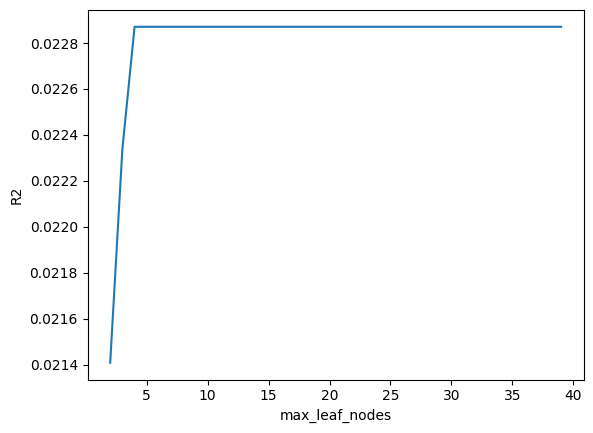

In [14]:
leaves = list(range(2, 40))
scores3 = pd.DataFrame(index=leaves, columns=['Test Score','Train Score'])
for leaf in leaves:
    dec_tree_fin = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth = 2, random_state=42)
    dec_tree_fin.fit(X_train, y_train)
    train_score = dec_tree_fin.score(X_train, y_train)
    test_score = dec_tree_fin.score(X_test, y_test)
    scores3.loc[leaf, 'Train Score'] = train_score
    scores3.loc[leaf, 'Test Score'] = test_score
plt.plot(leaves, scores3['Test Score'])
plt.xlabel('max_leaf_nodes')
plt.ylabel('R2');
sorted_scores3 = scores3.sort_values(by='Test Score', ascending=False)
sorted_scores3.head()

Anything above 5 is the same

In [15]:
dec_tree_fin = DecisionTreeRegressor(max_leaf_nodes = 26, max_depth = 2, random_state = 42)
dec_tree_fin.fit(X_train, y_train)
print('Train')
eval(y_train, dec_tree_fin.predict(X_train))
print('Test')
eval(y_test, dec_tree_fin.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.01
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


### Going to do a grid search to see if that gives us better results

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
model1 = DecisionTreeRegressor(random_state=42)
param_grid1 = {'max_leaf_nodes': [5,10,15,20,25,30,35,40],
               'min_samples_leaf': [5,10,15,20,25,30,35,40]}
grid_search1 = GridSearchCV(model1, param_grid1)
grid_search1.fit(X_train, y_train)
grid_search1.best_params_

{'max_leaf_nodes': 5, 'min_samples_leaf': 40}

In [18]:
dec_tree_grid = DecisionTreeRegressor(max_leaf_nodes = 5, min_samples_leaf = 40, random_state = 42)
dec_tree_grid.fit(X_train, y_train)
print('Train')
eval(y_train, dec_tree_grid.predict(X_train))
print('Test')
eval(y_test, dec_tree_grid.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


## This model is really weak, have to try some other things.  Maybe neural net, but first try bagging regressor or random forest

In [19]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [20]:
bagreg = BaggingRegressor(random_state = 42)

In [21]:
bagreg = DecisionTreeRegressor(random_state = 42)
bag_pipe = make_pipeline(scaler, bagreg)
bag_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [22]:
bagreg_train_score = bagreg.score(X_train, y_train)
bagreg_test_score = bagreg.score(X_test, y_test)
print('Train')
eval(y_train, bagreg.predict(X_train))
print('Test')
eval(y_test, bagreg.predict(X_test))

Train
scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.01 
R2: 1.00
Test
scores: 
MAE: 0.23 
MSE: 0.12 
RMSE: 0.34 
R2: -1.02


As expected this model is similarly weak, but we can practice tuning.

In [23]:
bagreg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

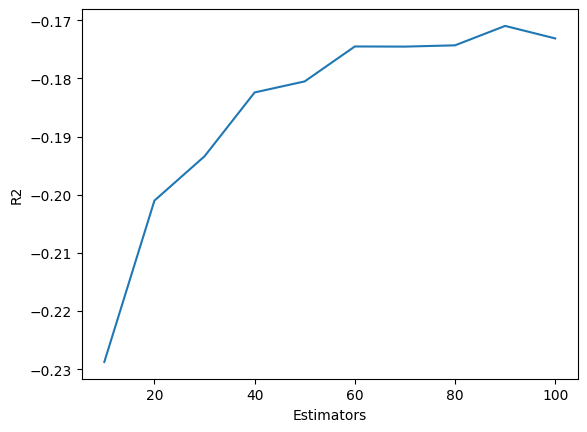

,Train Score,Test Score
90,0.830826,-0.170974
100,0.831026,-0.173126
80,0.829374,-0.174311
60,0.826683,-0.174506
70,0.828214,-0.174531
50,0.825386,-0.18051
40,0.821927,-0.182413
30,0.817193,-0.193389
20,0.806372,-0.201013
10,0.774301,-0.228747


In [24]:
estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bag_scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train, y_train)
   bag_train_score = bag_reg.score(X_train, y_train)
   bag_test_score = bag_reg.score(X_test, y_test)
   bag_scores.loc[num_estimators, 'Train Score'] = bag_train_score
   bag_scores.loc[num_estimators, 'Test Score'] = bag_test_score

plt.xlabel('Estimators')
plt.ylabel('R2');
plt.plot(bag_scores['Test Score'])
plt.show()
bag_scores = bag_scores.sort_values(by='Test Score', ascending=False)
bag_scores

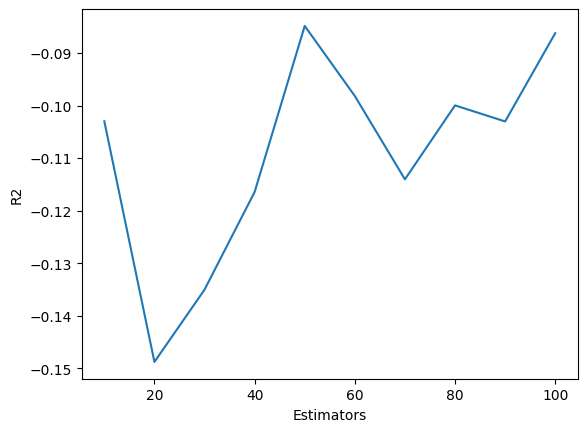

,Train Score,Test Score
50,-0.068685,-0.084852
100,-0.056062,-0.08623
60,-0.093767,-0.098186
80,-0.092393,-0.099967
10,-0.077824,-0.102988
90,-0.090102,-0.103021
70,-0.087891,-0.114034
40,-0.08719,-0.116442
30,-0.101428,-0.135024
20,-0.123729,-0.148769


In [25]:
samples = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bag_scores2 = pd.DataFrame(index=samples, columns=['Train Score', 'Test Score'])
for sample in samples:
   bag_reg_fin = BaggingRegressor(max_samples=sample, random_state=42)
   bag_reg_fin.fit(X_train, y_train)
   bag_train_score = bag_reg_fin.score(X_train, y_train)
   bag_test_score = bag_reg_fin.score(X_test, y_test)
   bag_scores2.loc[sample, 'Train Score'] = bag_train_score
   bag_scores2.loc[sample, 'Test Score'] = bag_test_score

plt.xlabel('Estimators')
plt.ylabel('R2');
plt.plot(bag_scores2['Test Score'])
plt.show()
bag_scores2 = bag_scores2.sort_values(by='Test Score', ascending=False)
bag_scores2

In [26]:
model2 = BaggingRegressor(random_state=42)
param_grid2 = {'n_estimators': [5,10,15,20,25,30,35,40],
              'max_samples': [5,10, 15, 25, 30, 35, 40]}
dt_grid_search2 = GridSearchCV(model2, param_grid2)
dt_grid_search2.fit(X_train, y_train)
dt_grid_search2.best_params_

{'max_samples': 30, 'n_estimators': 40}

In [27]:
bag_reg_fin = BaggingRegressor(max_samples=30, n_estimators=40, random_state=42)
bag_reg_fin.fit(X_train, y_train)
print('Train')
eval(y_train, bag_reg_fin.predict(X_train))
print('Test')
eval(y_test, bag_reg_fin.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: -0.01
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: -0.02


Can't fix tuning this, but exercise done.

## Random Forest Model

In [28]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Base model accuracy

In [29]:
print('Train')
eval(y_train, rf.predict(X_train))
print('Test')
eval(y_test, rf.predict(X_test))

Train
scores: 
MAE: 0.07 
MSE: 0.01 
RMSE: 0.10 
R2: 0.83
Test
scores: 
MAE: 0.19 
MSE: 0.07 
RMSE: 0.26 
R2: -0.17


Base model is still pretty weak, hopefully we can better tune this to replicate the data's results

In [30]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

,Test Score,Train Score
5,0.021902,0.04566
10,-0.004167,0.214548
15,-0.055995,0.476756
20,-0.116018,0.668747
25,-0.15965,0.762944


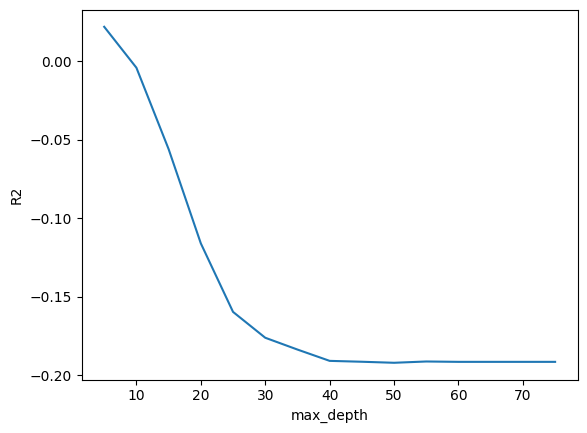

In [32]:
depths2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
bag_scores2 = pd.DataFrame(index=depths2, columns=['Test Score','Train Score'])
for depth2 in depths2:
    bagforest = RandomForestRegressor(max_depth=depth2, n_estimators=30, random_state=42)
    bagforest.fit(X_train, y_train)
    bagforest_train_score = bagforest.score(X_train, y_train)
    bagforest_test_score = bagforest.score(X_test, y_test)
    bag_scores2.loc[depth2, 'Train Score'] = bagforest_train_score
    bag_scores2.loc[depth2, 'Test Score'] = bagforest_test_score
plt.plot(depths2, bag_scores2['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');
bag_scores2 = bag_scores2.sort_values(by='Test Score', ascending=False)
bag_scores2.head()

In [33]:
model3 = RandomForestRegressor(random_state=42)
param_grid3 = {'max_depth': [5,10,15,20,25,30,35,40],
               'n_estimators': [5,10,15,20,25,30,35,40],
               'max_leaf_nodes': [5,10,15,20,25,30,35,40]}
grid_search3 = GridSearchCV(model3, param_grid3)
grid_search3.fit(X_train, y_train)
grid_search3.best_params_

{'max_depth': 5, 'max_leaf_nodes': 5, 'n_estimators': 15}

In [34]:
rf_grid = RandomForestRegressor(max_leaf_nodes = 5, max_depth = 5, n_estimators = 10, random_state=42)
rf_grid.fit(X_train, y_train)
print('Train')
eval(y_train, rf_grid.predict(X_train))
print('Test')
eval(y_test, rf_grid.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


As expected, the R squared value isn't strong enough for any of these models.  Hoping that a neural net or KMeans will do better.